# Chapter 17: Sparse Recovery from One-Bit Observations 

In [1]:
import numpy as np
from numpy import linalg as LA 
import matplotlib.pyplot as plt
import time
import cvxpy as cp

## Estimating the direction from one-bit observations

Here, the binary observations made on a vector $x\in\mathbb{R}^N$ with $\|x\|_2=1$ and $\|x\|_0\leq s$ take the form
$$ y_i = \mathrm{sgn}\big( \langle a^{(i)},x\rangle \big), \quad i=1,\dots,m.$$

In [2]:
# generate a normalized s-sparse vector together with its one-bit observation vector
N = 200            # ambient dimension
s = 8              # sparsity level
m = 20000          # number of observation
# create the vector x to be recovered
x = np.zeros(N)
supp = np.sort(np.random.permutation(N)[:s])
x[supp] = np.random.randn(s)
x = x/LA.norm(x)
# produce the one-bit observation vector y 
A = np.sqrt(np.pi/2)/m*np.random.randn(m,N)
y = np.sign(A@x)

### The direction of x is well approximated by the outputs of the hard thresholding and the linear programming procedures, namely by

- $ x_{\rm ht} = H_s(A^\top y) ;$
- $ x_{\rm lp} = \underset{z,c\in\mathbb{R}^N}{\mathrm{argmin}}\; \sum_{i=1}^{m} c_i \quad \mbox{ subject to } \quad -c\leq z\leq c, \quad \sum_{i=1}^{m}y_i\langle a^{(i)},z\rangle=1, \quad y_i\langle a^{(i)},z\rangle\geq0, \;i=1,\dots,m. $

In [3]:
t_ht_start = time.perf_counter()
x_ht = np.zeros(N)
aux = A.T @ y
idx = np.argsort(-abs(aux))
x_ht[idx[:s]] = aux[idx[:s]]
t_ht_stop = time.perf_counter()
t_ht = t_ht_stop - t_ht_start
rel_error_ht = LA.norm(x-x_ht)
print('Hard thresholding took  {:.3f} sec to approximate x with (relative) L2-error {:.2e}'
      .format(t_ht,rel_error_ht))
t_lp_start = time.perf_counter()
x_lp = cp.Variable(N)
c = cp.Variable(N)
objective = cp.Minimize(cp.sum(c))
constraints = [ cp.sum(cp.multiply(y,A@x_lp)) == 1 ]
constraints+= [ cp.multiply(y, A@x_lp) >= 0 ]
constraints+= [c + x_lp >= 0]
constraints+= [c - x_lp >= 0]
lp = cp.Problem(objective,constraints)
lp.solve(solver='ECOS')
t_lp_stop = time.perf_counter()
t_lp = t_lp_stop - t_lp_start
x_lp = x_lp.value
rel_error_lp = LA.norm(x-x_lp)
print('Linear programming took {:.2f} sec to approximate x with (relative) L2-error {:.2e}'
      .format(t_lp,rel_error_lp))

Hard thresholding took  0.002 sec to approximate x with (relative) L2-error 4.48e-02
Linear programming took 24.46 sec to approximate x with (relative) L2-error 3.78e-03


## Dependence of the estimation error on the number of one-bit observations

Introducing the ration $\lambda = \dfrac{m}{s\ln(eN/s)}$, one expects a behavior of the type $\epsilon \leq D\lambda^{-c}$ for the estimation error $\epsilon$, i.e. $\ln(\epsilon) \leq -c\ln(\lambda) +\ln(D)$.
<br>
For hard thresholding (the only procedure tested below as linear programming would take too long), Theorem 17.2 reveals that one can take  𝑐=1/6 , which is in fact improvable to  𝑐=1/2  (see Exercise 17.2).

In [4]:
N = 200 
s = 8
n_tests = 500
m_min = 10000
m_max = 30000
m_inc = 1000
ratio = np.zeros(int((m_max-m_min)/m_inc+1))
error_ht = np.zeros((n_tests,int((m_max-m_min)/m_inc+1)))
t_experiment_start = time.perf_counter()
for t in range(n_tests):
    x = np.zeros(N)
    supp = np.sort(np.random.permutation(N)[:s])
    x[supp] = np.random.randn(s);
    x = x/LA.norm(x);
    for m in range(m_min, m_max+m_inc, m_inc):
        A = np.sqrt(np.pi/2)/m * np.random.randn(m,N)
        y = np.sign(A@x)
        x_ht = np.zeros(N)
        aux = A.T@y
        idx = np.argsort(-abs(aux))
        x_ht[idx[:s]] = aux[idx[:s]]
        ratio[int((m-m_min)/m_inc)] = m/s/np.log(np.exp(1)*N/s)
        error_ht[t,int((m-m_min)/m_inc)] = LA.norm(x-x_ht)
t_experiment_stop = time.perf_counter()
t_experiment = t_experiment_stop - t_experiment_start

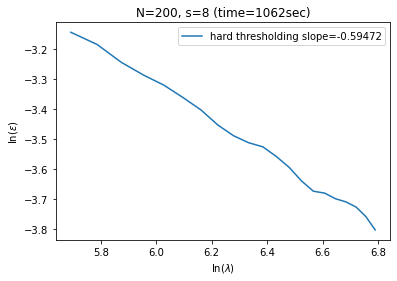

In [5]:
# visualize the result
aux = np.polyfit(np.log(ratio),np.log(np.mean(error_ht,axis=0)),1)
slope_ht = aux[0]
plt.plot(np.log(ratio),np.log(np.mean(error_ht,axis=0)))
plt.xlabel('ln($\lambda$)')
plt.ylabel('ln($\epsilon$)')
plt.legend(['hard thresholding slope={:.5f}'.format(slope_ht)])
plt.title('N={}, s={} (time={:.0f}sec)'.format(N,s,np.round(t_experiment)))
plt.show()

## Estimating both the direction and the magitude from one-bit observations

Here, the binary observations made on a vector $x\in\mathbb{R}^N$ with $\|x\|_2\leq1$ and $\|x\|_0\leq s$ take the form
$$ y_i = \mathrm{sgn}\big( \langle a^{(i)},x\rangle - \theta_i \big), \quad i=1,\dots,m.$$
The vector $x\in\mathbb{R}^N$ is fully approximated through the estimation of the direction of the augmented vector $\tilde{x} = [x;1]\in\mathbb{R}^{N+1}$ via "lifted" versions of the hard thresholding and the linear programming procedures.

In [6]:
# select problem sizes
N = 200 
s = 8
m = 20000
# create the sparse vector x to be recovered
x = np.zeros(N)
supp = np.sort(np.random.permutation(N)[:s])
x[supp] = np.random.randn(s)
x = np.random.rand(1)*x/LA.norm(x)
# produce the observation vector y
A = np.sqrt(np.pi/2)/m * np.random.randn(m,N)
theta = np.sqrt(np.pi/2)/m * np.random.randn(m)
y = np.sign(A@x-theta)
A_tilde = np.column_stack((A,-theta))

In [7]:
# estimation via lifted hard thresholding 
t_ht_start = time.perf_counter()
x_tilde_ht = np.zeros(N+1)
aux = A_tilde.T@y
idx = np.argsort(-abs(aux))
x_tilde_ht[idx[:s+1]] = aux[idx[:s+1]]
x_ht = x_tilde_ht[:N]/x_tilde_ht[N]
t_ht_stop = time.perf_counter()
t_ht = t_ht_stop - t_ht_start
rel_error_ht = LA.norm(x-x_ht)/LA.norm(x)
print('Hard thresholding took  {:.3f} sec to approximate x with relative L2-error of {:.2e}'
      .format(t_ht, rel_error_ht))
# estimation via lifted linear programming
t_lp_start = time.perf_counter()
x_tilde_lp = cp.Variable(N+1)
c = cp.Variable(N+1)
objective = cp.Minimize(cp.sum(c))
constraints = [ cp.sum(cp.multiply(y,A_tilde@x_tilde_lp)) == 1 ]
constraints+= [ cp.multiply(y, A_tilde@x_tilde_lp) >= 0 ]
constraints+= [c + x_tilde_lp >= 0]
constraints+= [c - x_tilde_lp >= 0]
lp = cp.Problem(objective,constraints)
lp.solve(solver='ECOS')
x_lp = x_tilde_lp.value[:N]/x_tilde_lp.value[N]
t_lp_stop = time.perf_counter()
t_lp = t_lp_stop - t_lp_start
rel_error_lp = LA.norm(x-x_lp)/LA.norm(x)
print('Linear programming took {:.2f} sec to approximate x with relative L2-error of {:.2e}'
      .format(t_lp, rel_error_lp))

Hard thresholding took  0.002 sec to approximate x with relative L2-error of 6.49e-02
Linear programming took 26.82 sec to approximate x with relative L2-error of 8.51e-03
